# スネーク曲線を描画するためのサンプルスクリプト
4p-jma-snakeプロダクトを使って、以下の4種類の描画を行うテストを行った。
アンサンブルメンバーは4p-jma-snakeの決定論的な予測を加工して、適当に作成した。

1. シングルメンバーのスネーク曲線（位置ズレなし）
2. シングルメンバーのスネーク曲線（位置ズレあり）
3. アンサンブルメンバーのスネーク曲線（位置ズレなし）
4. アンサンブルメンバーのスネーク曲線（位置ズレあり）

In [1343]:
import xarray as xr
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')

In [1344]:
def calc_landslide_lisk_index(swi, p1h):
    # SWI（土壌雨量指数）と P1h(1時間積算雨量)から土砂災害危険度指数(index)を返す関数
    a = 1.0; b = 2.0          # （現状、a=1, b=2は適当に定義）
    index = a + swi + b * p1h # 土砂災害危険度指数
    return index

In [1345]:
def calc_maxloc(da):
    # 入力した xarray の DataArray(da) に対して、daの変数の値が最大となる LAT, LON を返す関数
    lon = da.coords["LON"]
    lat = da.coords["LAT"]
    maxloc = da.argmax(dim=["LON","LAT"])
    lon_max = lon[maxloc["LON"].data]
    lat_max = lat[maxloc["LAT"].data]
    return lon_max, lat_max

In [1346]:
def dxdy2dlondlat(Lx, Ly, lat1):
    # Lx: 経度方向の距離(km)
    # Ly: 経度方向の距離(km)
    R = 6371.0 # 地球平均半径(km)
    dlat = Ly * 360.0 / (2.0 * np.pi * R)
    dlon = Lx * 360.0 / (2.0 * np.pi * R * np.cos( 2.0 * np.pi * lat1 / 360.0) )
    return dlon, dlat

In [1347]:
def draw_snake_line(swi, p1h):
    # SWIとP1hからスネーク曲線の可視化するための関数
    #plt.plot(swi1, p1h1) # 簡単に可視化する場合はこの1行で可視化できる
    fs = 18
    plt.rcParams["font.size"]   = fs
    fig = plt.figure(figsize=(6,6))
    ax = fig.add_subplot(1, 1, 1)
    plt.title("Snake Line")
    plt.ylabel("P1h (mm)")
    plt.xlabel("SWI (mm)")
    plt.grid(which='major',color='gray',linestyle='-')
    # スネーク曲線を描画
    plt.plot(swi.isel(TIME=slice(6,13)), p1h.isel(TIME=slice(6,13)), color='blue',  marker='o', ms=10, lw=3) # FT =  0h ~ 6h  
    plt.plot(swi.isel(TIME=slice(0, 7)), p1h.isel(TIME=slice(0, 7)), color='black', marker='o', ms=10, lw=3) # FT = -6h ~ 0h
        # index は FT =  -6h ~ 6h で時間方向は TIME[0:12] と 13 データ
        # indexの TIMEの配列添字と予測時間の関係（0: FT=-6h, 6:FT=0h, 7: FT=1h, 12: FT=6h）  
    ax.set_xlim([0,250])
    ax.set_ylim([0,100])
#    ax.set_xlim([0,300])
#    ax.set_ylim([0,150])    

In [1348]:
def draw_landslide_lisk_index(index):
    # 土砂災害危険度指数の時系列を可視化するための関数
#    index.plot() # 簡単に可視化する場合はこの1行で可視化できる
    fs = 18
    plt.rcParams["font.size"]   = fs
    fig = plt.figure(figsize=(6,4))
    ax = fig.add_subplot(1, 1, 1)
    index.isel(TIME=slice(6,13)).plot.line(color='blue', marker='o', ms=10, lw=3) # FT =  0h ~ 6h
    index.isel(TIME=slice(0,7)).plot.line(color='black', marker='o', ms=10, lw=3) # FT = -6h ~ 0h
    #ind.isel(TIME=slice(6,13)).plot.line(color='blue') # FT = 0 ~ 6h
    #ind.isel(TIME=slice(6,13)).plot(marker='blue') # FT = 0 ~ 6h
    plt.grid(which='major',color='gray',linestyle='-')
#    plt.title("")
    plt.ylabel("Landslide lisk index (mm)")
    plt.xlabel("Time (MM-DD hh; UTC)")
#    ax.set_xlim([0,250])
    ax.set_ylim([0,400])

In [1349]:
# データの読み込み
nc = '../data/4p-jmasnake/4p-jmasnake_snakekyushu_2022-07-18_1800utc.nc' # 4p-jmasnake データの読み込み
ds  = xr.open_dataset(nc)
swi = ds["SWI"]
p1h = ds["P60"]

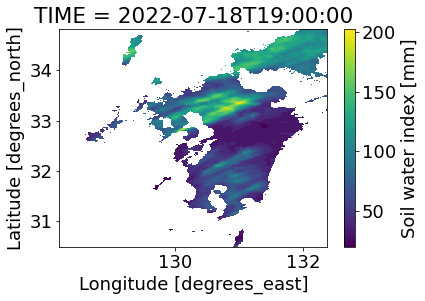

In [1350]:
# SWI(FT=1h) を可視化
swi.isel(TIME=7).plot()

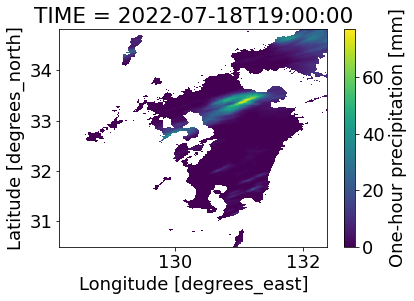

In [1351]:
# P1h(FT=1h) を可視化
p1h.isel(TIME=7).plot()

## (1) シングルメンバーのスネーク曲線（位置ズレなし）

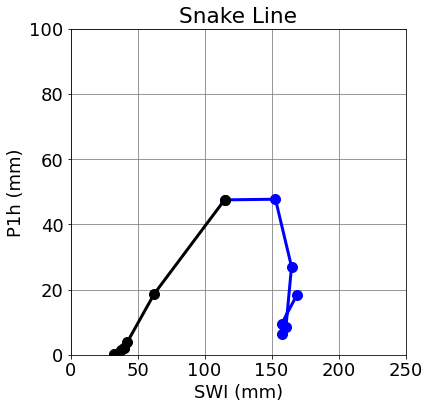

In [1352]:
# (1) シングルメンバーのスネーク曲線（位置ズレなし）

# クリックした LAT, LON を指定 （実際には、土壌雨量指数の2次元平面の下絵をクリックして取得する）
lon1 = 131.01; lat1 = 33.32 

# クリックした LAT, LON の最近傍 (nearest) における SWI と P1h を抽出
swi1 = swi.sel(LON=lon1, LAT=lat1, method="nearest") #  
p1h1 = p1h.sel(LON=lon1, LAT=lat1, method="nearest")

# スネーク曲線の描画
draw_snake_line(swi1, p1h1)

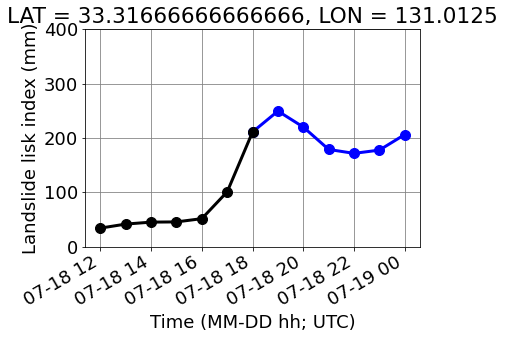

In [1353]:
# 危険度指標の計算
ind1 = calc_landslide_lisk_index(swi1, p1h1)

# 危険度指標の可視化
draw_landslide_lisk_index(ind1)

In [1354]:
lon = ds["LON"]
DLON = lon[1] - lon[0] # dLON = 0.0125 (deg) 
lat = ds["LAT"]
DLAT = lat[1] - lat[0] # dLAT = 0.0083333 (deg)

R = 6371.0
DY = R * (2.0 * np.pi) *  DLAT / 360.0                                       # dx = 1.16 (km)
DX = R * np.cos( 2.0 * np.pi * lat1 / 360.0)* (2.0 * np.pi) *  DLON / 360.0  # dy = 0.93 (km)
# => 格子間隔は正確には 1km ではない

## (2) シングルメンバーのスネーク曲線（位置ズレあり）

In [1355]:
# 位置ズレ許容の範囲を設定 （ Lx(km) x Ly(km) の範囲を抽出）
Lx = 15.0 # 経度方向の位置ズレ許容を行う距離 (km) # dlon = 0.161(deg)
Ly = 15.0 # 緯度方向の位置ズレ許容を行う距離 (km) # dlat = 0.135(deg)
dlon, dlat = dxdy2dlondlat(Lx, Ly, lat1)

# Lx, Ly を設定せずに、dlon, dlatを直接設定する場合
#dlon = 0.18; dlat = 0.125 # 位置ズレ許容の範囲(deg): この設定では 15 x 15 grids

# 位置ズレ許容の範囲を設定(緯度経度)
xmin = lon1 - dlon / 2.0; xmax = lon1 + dlon / 2.0
ymin = lat1 - dlat / 2.0; ymax = lat1 + dlat / 2.0

# 1. 位置ズレ許容の範囲（緯度経度）に対して、変数を抽出 # 番号1はスライド2の番号に対応
swi2 = swi.sel(LON=slice(xmin,xmax)).sel(LAT=slice(ymin,ymax)) 
p1h2 = p1h.sel(LON=slice(xmin,xmax)).sel(LAT=slice(ymin,ymax))

# 2. 土砂災害危険度指数の計算
ind2 = calc_landslide_lisk_index(swi2, p1h2)

# 予測部分を抽出
swi2_f = swi2.isel(TIME=slice(7,13)) # 予測部分の切り取り(FT=1h~6h)
p1h2_f = p1h2.isel(TIME=slice(7,13)) # 予測部分の切り取り(FT=1h~6h)
ind2_f = ind2.isel(TIME=slice(7,13)) # 予測部分の切り取り(FT=1h~6h)

# 3. 土砂災害危険度指数の予測部分(FT=1h~6h)に対して時間最大をとる
ind2_f_tmax = ind2_f.max("TIME") 

# 4. 土砂災害危険度指数の予測値の（時間）最大の２次元分布において、値が最大となる地点(x)の緯度経度を抽出
lon_max2, lat_max2 = calc_maxloc(ind2_f_tmax)
#print(lon_max2, lat_max2)

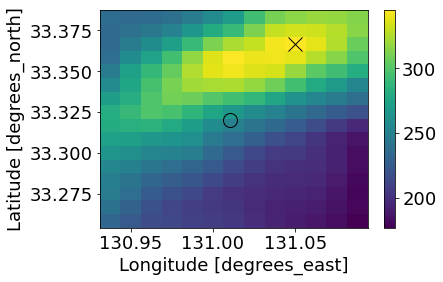

In [1356]:
# 可視化（土砂災害危険度指数の予測値が最大となる地点(x)が抽出できているか確認）

# 土砂災害危険度指数の（時間）最大値の2次元分布図を描く
ind2_f_tmax.plot()

# 指定した地点（クリックした地点）をoでプロット
plt.plot(lon1, lat1, marker='o', color='black', markersize=14, fillstyle='none', mew=1) 

# 土砂災害危険度指数が最大の地点をxでプロット
plt.plot(lon_max2, lat_max2, marker='x', color='black', markersize=14, fillstyle='none', mew=1) 

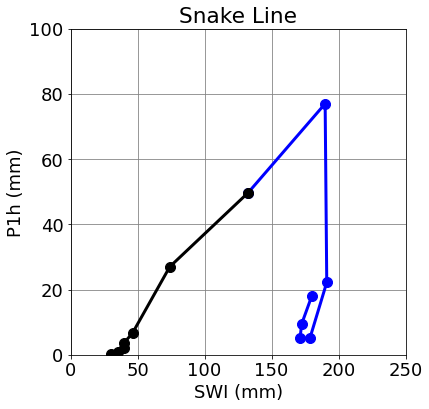

In [1357]:
# スネーク曲線を描くための土壌雨量指数と1時間積算雨量の抽出(xの位置)
swi2_max = swi2.sel(LON=lon_max2, LAT=lat_max2, method="nearest") # x の位置の土壌雨量
p1h2_max = p1h2.sel(LON=lon_max2, LAT=lat_max2, method="nearest") # x の位置の1時間積算雨量

# x の位置のスネーク曲線の描画
draw_snake_line(swi2_max, p1h2_max) 

クリックした位置(o)のスネーク曲線(1で描いた図を以下に再掲)に比べ、スネーク曲線が右上に移動しており、より危険な場所を抽出きていることがわかる

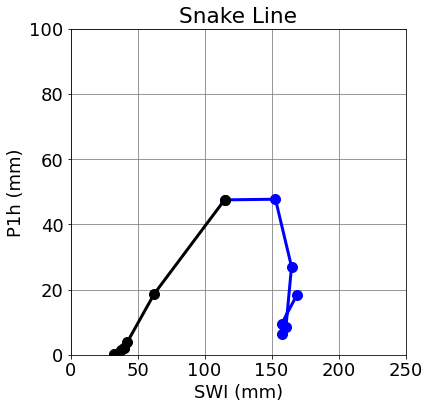

In [1358]:
draw_snake_line(swi1, p1h1) 

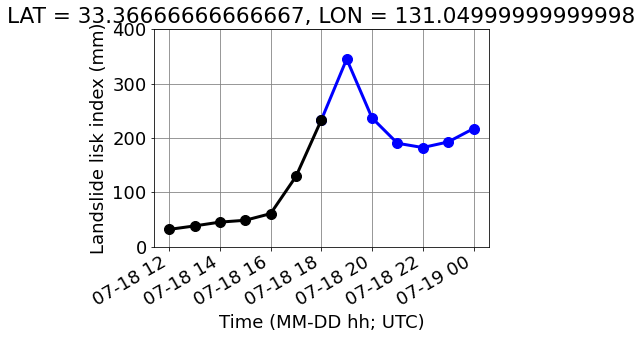

In [1359]:
# xの地点における危険度指標の計算（参考）
ind2_max = calc_landslide_lisk_index(swi2_max, p1h2_max)

# xの地点における危険度指標の可視化（参考）
draw_landslide_lisk_index(ind2_max)

## (3)アンサンブルメンバーのスネーク曲線（位置ズレなし）

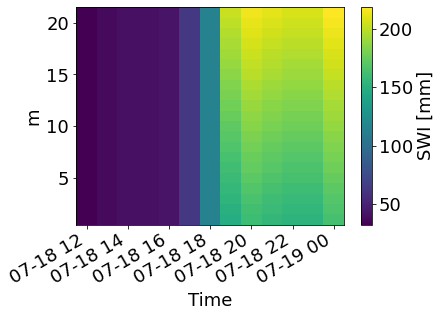

In [1360]:
#(3)アンサンブルメンバーのスネーク曲線（位置ズレなし）

nmax = 21 # アンサンブル数（メソアンサンブルと同じ21を指定）

# 1. クリックした LAT, LON の SWI と P1h を抽出 （実際には、土壌雨量指数の2次元平面の下絵をクリックして取得する）
swi3 = swi.sel(LON=lon1, LAT=lat1, method="nearest") 
p1h3 = p1h.sel(LON=lon1, LAT=lat1, method="nearest")

def set_ensemble(nmax, da):
    # 4p-jmasnake の変数(SWIとP1h)から疑似アンサンブルメンバーを作成するための関数
    times = da.TIME 
    var0  = da.data
    var = np.zeros([nmax, times.size]) # ndarray の作成

    n_member = np.arange(1, nmax+1) # アンサンブルメンバー数の配列 1, 2, ..., 21(nmax) を作成


    d = np.linspace(-5, 50, nmax) # アンサンブルを作成するための差分
                                  #    array([-5.  , -3.75, -2.5 , -1.25,  0.  ,  1.25,  2.5 ,  3.75,  5.  ,
                                  #         6.25,  7.5 ,  8.75, 10.  , 11.25, 12.5 , 13.75, 15.  , 16.25,
                                  #        17.5 , 18.75, 20.  ])

    #np.random.seed(seed=1)           # 乱数を使って差分を作る場合
    #d = (np.random.rand(nmax)) * 50  # はコメントアウトして利用可能（ただし、乱数が小さい場合もととなるメンバーからのズレが小さいため、
                                     # 可視化したときに線が重なり、指定したメンバー数が与えられたかどうかの確認が困難になることに注意）

    for i in range(nmax):
        var[i, 0:7]  = var0[0:7]         # 過去~解析値まではそのまま
        var[i, 7:13] = var0[7:13] + d[i] # 予測値に差分を足して疑似アンサンブルメンバーを作成

#        var0[7:13] = np.roll(var0[7:13], 1, axis=0) # 時間方向に1時間シフト（時間方向にMAXが取れているか確認する際にコメントアウトして利用）

    # ndarray から xarray の DataArrayを作成
    da_ou = xr.DataArray(var, coords=[n_member, times], dims=['m', 'TIME'])
    da_ou.name = da.name                     # 入力された DataArray の名前を入力
    da_ou.attrs['units'] = da.attrs['units'] # 入力された DataArray の units (SWIとP1hに対しては mm)を入力

    return da_ou

# 疑似アンサンブルメンバーの作成 (SWIとP1hに nmax メンバーを設定) 
swi3_e = set_ensemble(nmax, swi3)
p1h3_e = set_ensemble(nmax, p1h3)

# swi(m, time) を可視化
swi3_e.plot()
#p1h3_e.plot()

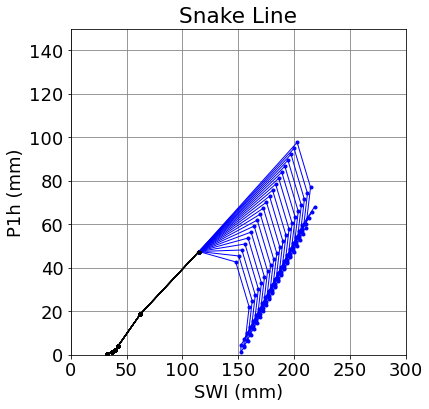

In [1361]:
# スネーク曲線の可視化

def draw_snake_line_ens(swi, p1h, nmax):
    # アンサンブルメンバーのスネーク曲線の可視化するための
    #plt.plot(swi1, p1h1) # スネーク曲線
    fs = 18
    plt.rcParams["font.size"]   = fs
    fig = plt.figure(figsize=(6,6))
    ax = fig.add_subplot(1, 1, 1)
    plt.title("Snake Line")
    plt.ylabel("P1h (mm)")
    plt.xlabel("SWI (mm)")
    plt.grid(which='major',color='gray',linestyle='-')

    for i in range(nmax):
#        print(i)
        x = swi.isel(m=i)
        y = p1h.isel(m=i)
        plt.plot(x.isel(TIME=slice(6,13)), y.isel(TIME=slice(6,13)), color='blue',  marker='o', ms=3, lw=1) # スネーク曲線
        plt.plot(x.isel(TIME=slice(0, 7)), y.isel(TIME=slice(0, 7)), color='black', marker='o', ms=3, lw=1) # スネーク曲線
         
#    ax.set_xlim([0,250])
#    ax.set_ylim([0,100])
    ax.set_xlim([0,300])
    ax.set_ylim([0,150])  

draw_snake_line_ens(swi3_e, p1h3_e, nmax)

In [1362]:
def draw_landslide_lisk_index_ens(index, nmax):
    # アンサンブルメンバーの土砂災害危険度指数を可視化するための関数
#    index.plot()
    fs = 18
    plt.rcParams["font.size"]   = fs
    fig = plt.figure(figsize=(6,4))
    ax = fig.add_subplot(1, 1, 1)    
    for i in range(nmax):  
        index.isel(m=i).isel(TIME=slice(6,13)).plot.line(color='blue', marker='o', ms=2, lw=1) # FT = 0 ~ 6h
        index.isel(m=i).isel(TIME=slice(0,7)).plot.line(color='black', marker='o', ms=2, lw=1) # 0: FT=-6h, 6:FT=0h, 7: FT=1h, 12: FT=6h
    plt.grid(which='major',color='gray',linestyle='-')
#    plt.title("")
    plt.ylabel("Landslide lisk index (mm)")
    plt.xlabel("Time (MM-DD hh; UTC)")
#    ax.set_xlim([0,250])
    ax.set_ylim([0,400])

In [1363]:
# 2. 危険度指標の計算
ind3 = calc_landslide_lisk_index(swi3_e, p1h3_e)

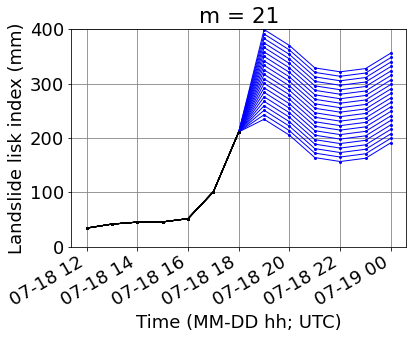

In [1364]:
# 危険度指標の可視化
draw_landslide_lisk_index_ens(ind3, nmax)

In [1365]:
# 各アンサンブルメンバーに対して土砂災害危険度指数の予測値が時間方向に最大となる index (in_maxloc) を取得
it_maxloc = ind3.isel(TIME=slice(7,13)).argmax(dim="TIME")  # 土砂災害危険度指数の予測データ[7:13]に対して時間方向に最大となる index を計算
it_maxloc += 7 # 過去と現在(FT=-6h~0h)も含めた index に変換
it_maxloc.data

array([7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7])

In [1366]:
# 3. 各メンバーの土砂災害危険度指数の予測値の最大値を計算

ind3_itmax = np.zeros(nmax) # 各メンバーの土砂災害危険度指数の予測値の最大値

for m in range(nmax): 
    it = it_maxloc[m]
    ind3_itmax[m] = ind3[m,it]
    
ind3_itmax

array([234.30001068, 242.55001068, 250.80001068, 259.05001068,
       267.30001068, 275.55001068, 283.80001068, 292.05001068,
       300.30000305, 308.55000305, 316.80000305, 325.05000305,
       333.30000305, 341.55000305, 349.80000305, 358.05000305,
       366.30000305, 374.55000305, 382.80000305, 391.05000305,
       399.30000305])

In [1367]:
# 4. アンサンブル最大・中央・最小となるメンバー番号を計算
n_member = np.arange(1, nmax+1) # => array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21])
x1 = pd.Series(ind3_itmax, index=n_member) # pandasの Series の作成
x2 = x1.sort_values(ascending=False)       # 
x3 = x2.index
x2

21    399.300003
20    391.050003
19    382.800003
18    374.550003
17    366.300003
16    358.050003
15    349.800003
14    341.550003
13    333.300003
12    325.050003
11    316.800003
10    308.550003
9     300.300003
8     292.050011
7     283.800011
6     275.550011
5     267.300011
4     259.050011
3     250.800011
2     242.550011
1     234.300011
dtype: float64

In [1368]:
m_max = x3[0]          #アンサンブル最大のメンバー番号
m_med = x3[(nmax-1)/2] # アンサンブル中央のメンバー番号
m_min = x3[nmax-1]     # アンサンブル最小のメンバー番号
print ('m_max =', m_max, ', m_median =', m_med, ', m_min =', m_min)

m_max = 21 , m_median = 11 , m_min = 1


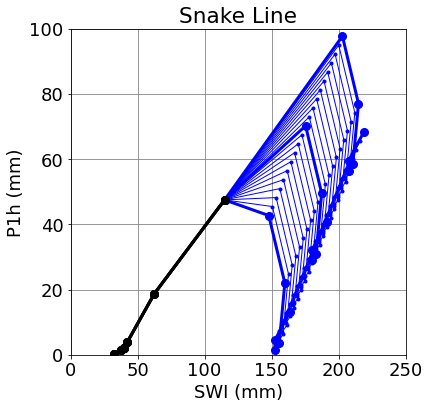

In [1369]:
# アンサンブルメンバーのスネーク曲線の可視化

def draw_snake_line_ens2(swi, p1h, nmax, m_max, m_med, m_min):
    # アンサンブルメンバーのスネーク曲線の可視化するための関数
    #plt.plot(swi1, p1h1) # スネーク曲線
    fs = 18
    plt.rcParams["font.size"]   = fs
    fig = plt.figure(figsize=(6,6))
    ax = fig.add_subplot(1, 1, 1)
    plt.title("Snake Line")
    plt.ylabel("P1h (mm)")
    plt.xlabel("SWI (mm)")
    plt.grid(which='major',color='gray',linestyle='-')

    def draw_line(swi, p1h, i, ms, lw):
        x = swi.isel(m=i)
        y = p1h.isel(m=i)
        plt.plot(x.isel(TIME=slice(6,13)), y.isel(TIME=slice(6,13)), color='blue',  marker='o', ms=ms, lw=lw) # スネーク曲線
        plt.plot(x.isel(TIME=slice(0, 7)), y.isel(TIME=slice(0, 7)), color='black', marker='o', ms=ms, lw=lw) # スネーク曲線


    for i in range(nmax):
#        print(i)
        ms = 3; lw = 1
        draw_line(swi, p1h, i, ms, lw)

    # アンサンブル最大・中央・最小のメンバーを太字と大きな●でプロット
    ms = 8; lw = 3
    draw_line(swi, p1h, m_max-1, ms, lw)
    draw_line(swi, p1h, m_med-1, ms, lw)
    draw_line(swi, p1h, m_min-1, ms, lw)
        
    ax.set_xlim([0,250])
    ax.set_ylim([0,100])

draw_snake_line_ens2(swi3_e, p1h3_e, nmax, m_max, m_med, m_min)

## (4)アンサンブルメンバーのスネーク曲線（位置ズレあり）

In [1383]:
# %%timeit # => 2 ms ± 127 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
# 位置ズレ許容の範囲を設定 （ Lx(km) x Ly(km) の範囲を抽出）
Lx = 15.0 # 経度方向の位置ズレ許容を行う距離 (km) # dlon = 0.161(deg)
Ly = 15.0 # 緯度方向の位置ズレ許容を行う距離 (km) # dlat = 0.135(deg)
dlon, dlat = dxdy2dlondlat(Lx, Ly, lat1)

# Lx, Ly を設定せずに、dlon, dlatを直接設定する場合
#dlon = 0.18; dlat = 0.125 # 位置ズレ許容の範囲(deg): この設定では 15 x 15 grids

# 位置ズレ許容の範囲を設定(緯度経度)
xmin = lon1 - dlon / 2.0; xmax = lon1 + dlon / 2.0
ymin = lat1 - dlat / 2.0; ymax = lat1 + dlat / 2.0

# 位置ズレ許容の範囲（緯度経度）に対して、変数を抽出 # 番号1はスライド2の番号に対応
swi4 = swi.sel(LON=slice(xmin,xmax)).sel(LAT=slice(ymin,ymax)) 
p1h4 = p1h.sel(LON=slice(xmin,xmax)).sel(LAT=slice(ymin,ymax))

def set_ensemble2(nmax, da):
    # 4p-jmasnake の変数(SWIとP1h)から疑似アンサンブルメンバーを作成するための関数
    times = da.TIME
    lon = da.LON
    lat = da.LAT
    var0 = da.data
    var = np.zeros([nmax, times.size, lat.size, lon.size])

    n_member = np.arange(1, nmax+1)
    d = np.linspace(-5, 50, nmax)

    #np.random.seed(seed=1)           # 乱数を使って差分を作る場合
    #d = (np.random.rand(nmax)) * 50  # はコメントアウトして利用可能（ただし、乱数が小さい場合もととなるメンバーからのズレが小さいため、
                                     # 可視化したときに線が重なり、指定したメンバー数が与えられたかどうかの確認が困難になることに注意）        
        
    for i in range(nmax):
      
        var[i, 0:7 ,:,:]  = var0[0:7 , :, :]        # 過去~解析値まではそのまま
        var[i, 7:13,:,:]  = var0[7:13, :, :] + d[i] # 予測値に差分を足して疑似アンサンブルメンバーを作成
        
        var0[7:13, :, :] = np.roll(var0[7:13, :, :], 1, axis=2) # 経度方向に-1グリッドシフト
        var0[7:13, :, :] = np.roll(var0[7:13, :, :], 1, axis=1) # 緯度方向に-1グリッドシフト        
#        var0 = np.roll(var0, 1, axis=2) # 経度方向に-1グリッドシフト
#        var0 = np.roll(var0, 1, axis=1) # 緯度方向に-1グリッドシフト        

    da_ou = xr.DataArray(var, coords=[n_member, times, lat, lon], dims=['m', 'TIME', 'LAT', 'LON'])
    da_ou.name = da.name
    da_ou.attrs['units'] = da.attrs['units']
    return da_ou


# 疑似アンサンブルメンバーの作成 (nmaxメンバー) 
swi4_e = set_ensemble2(nmax, swi4)
p1h4_e = set_ensemble2(nmax, p1h4)
#swi4_e

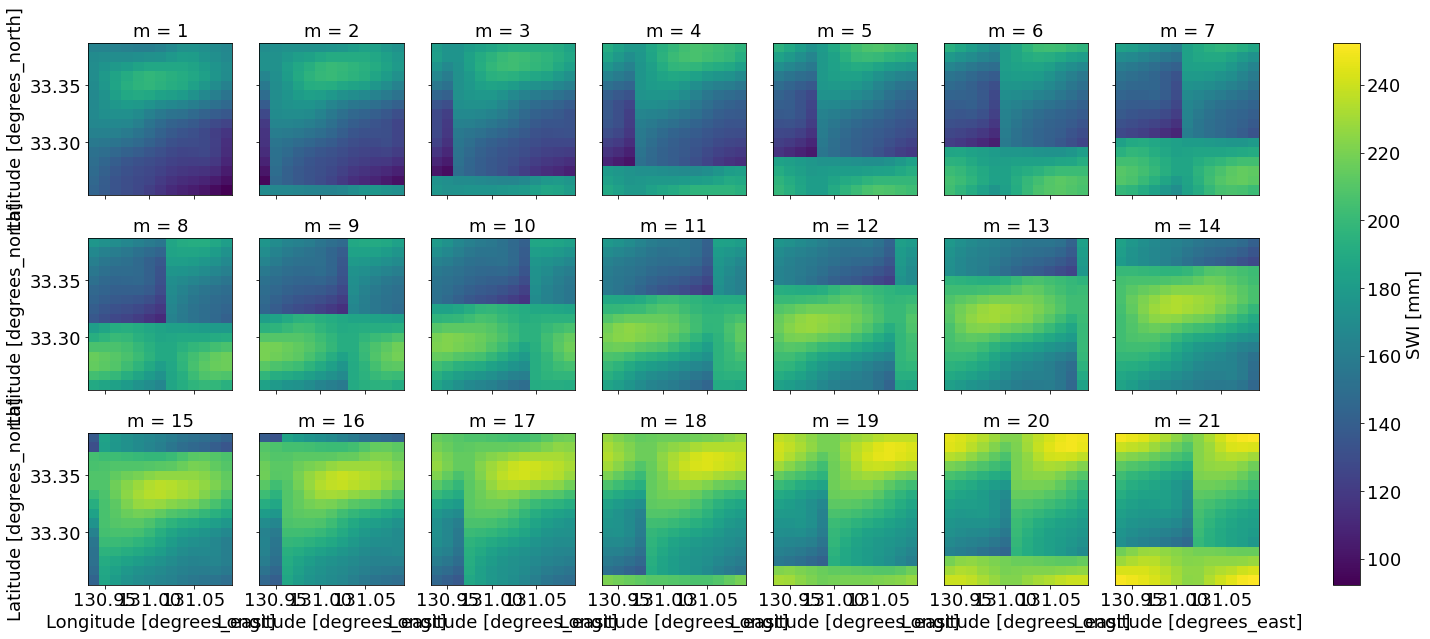

In [1384]:
# SWI or P1h の FT = 1h を可視化
swi4_e.isel(TIME=7).plot(x="LON", y="LAT", col="m", col_wrap=7)
#p1h4_e.isel(TIME=7).plot(x="LON", y="LAT", col="m", col_wrap=7) 

In [1385]:
#%%timeit # => 586 µs ± 4.45 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
# 2. 土砂災害危険度指数の計算
ind4_e = calc_landslide_lisk_index(swi4_e, p1h4_e)

# 予測部分の切り取り
swi4_e_f = swi4_e.isel(TIME=slice(7,13)) 
p1h4_e_f = p1h4_e.isel(TIME=slice(7,13)) 
ind4_e_f = ind4_e.isel(TIME=slice(7,13)) 

# 3. 各メンバーに対する土砂災害危険度の予測値の（時間）最大を計算
ind4_e_f_tmax = ind4_e_f.max("TIME") # 各メンバーのFT=1h~6h に対して時間最大をとる

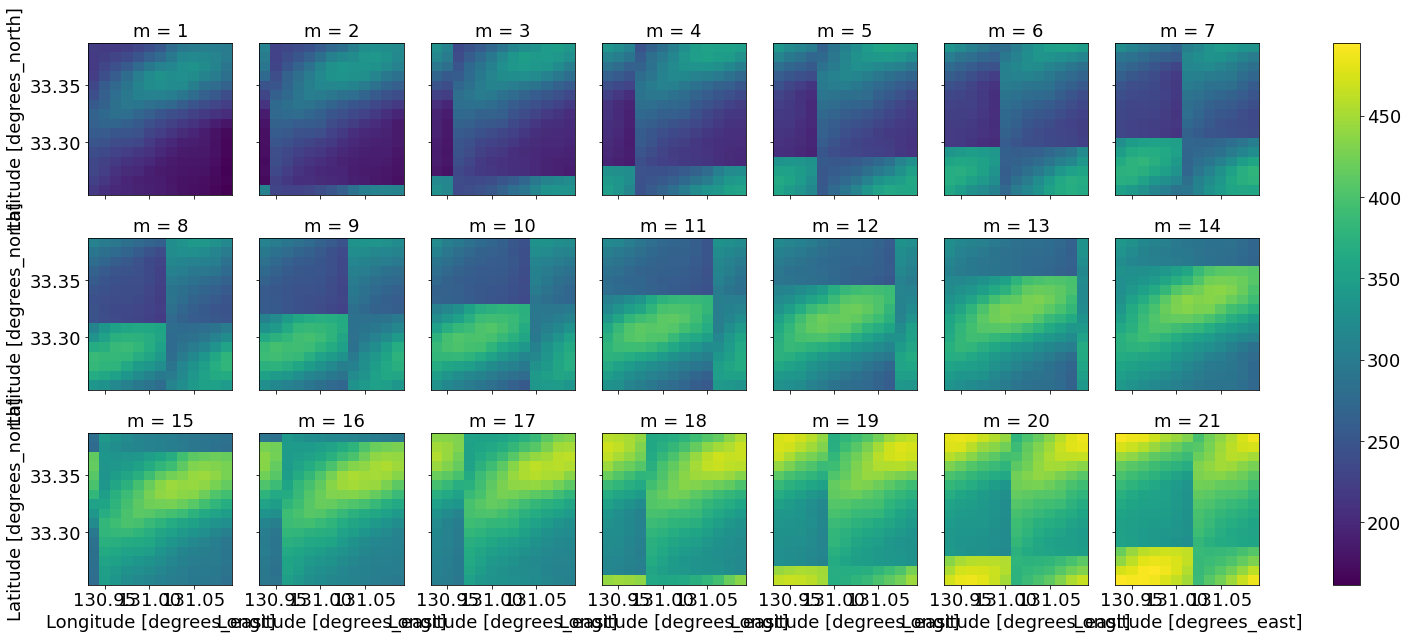

In [1386]:
# 各メンバーに対する土砂災害危険度の予測値の（時間）最大を描画
ind4_e_f_tmax.plot(x="LON", y="LAT", col="m", col_wrap=7)

In [1387]:
# %%timeit # => 22.5 ms ± 312 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
# 各メンバーに対する土砂災害危険度指数の（時間）最大値（lon, lat）が最大となる地点(x)の緯度経度を計算し、
# その地点の SWI と P1hを抽出
lon_max4_e = np.zeros(nmax)
lat_max4_e = np.zeros(nmax)

it_max = ind4_e.TIME.size
swi4_max_e = np.zeros([nmax, it_max])
p1h4_max_e = np.zeros([nmax, it_max])

for m in range(nmax): 
#for m in range(2): 

    # メンバー毎に土砂災害危険度指数の（時間）最大値が最大となる地点(x)の緯度経度を抽出
    lon_max4, lat_max4 = calc_maxloc(ind4_e_f_tmax[m])
#    draw_ind(ind4_e_f_tmax[m], lon1, lat1, lon_max4, lat_max4) 

    # メンバー毎に x の地点の SWIと P1hを抽出
    swi4_max = swi4_e.isel(m=i).sel(LON=lon_max4, LAT=lat_max4, method="nearest") 
    p1h4_max = p1h4_e.isel(m=i).sel(LON=lon_max4, LAT=lat_max4, method="nearest") 

    # 配列に代入
    lon_max4_e[m] = lon_max4
    lat_max4_e[m] = lat_max4
    swi4_max_e[m, :] = swi4_max
    p1h4_max_e[m, :] = p1h4_max
        
#lon_max4_e
#lat_max4_e
#swi4_max_e.shape
#p1h4_max_e.shape
#swi4_max_e.plot()

In [1388]:
# 土砂災害危険度指数の最大値(lon, lat)の2次元図の描画
def draw_ind(ind, lon1, lat1, lon_max4, lat_max4): 
    # 土砂災害危険度指数の最大値(ind)の2次元図（シェード）、クリックした地点（o）、 indが最大となる地点（x）を描画する関数
    
    fs = 18
    plt.rcParams["font.size"]   = fs
    fig = plt.figure(figsize=(6,4))
    ax = fig.add_subplot(1, 1, 1)
    # 土砂災害危険度指数の（時間）最大値を描く
    ind.plot()
    # 指定した地点（土壌雨量指数の下絵に対してクリックした地点）をoでプロット
    plt.plot(lon1, lat1, marker='o', color='black', markersize=14, fillstyle='none', mew=1) 
    # 土砂災害危険度指数が最大の地点をxでプロット
    plt.plot(lon_max4, lat_max4, marker='x', color='black', markersize=14, fillstyle='none', mew=1) 
    
#for m in range(nmax): 
#    draw_ind(ind4_e_f_tmax[m], lon1, lat1, lon_max4_e[m], lat_max4_e[m]) 

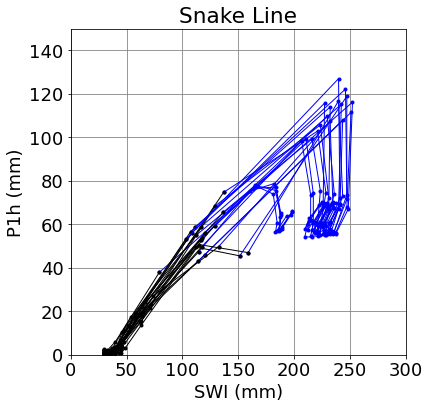

In [1389]:
# スネーク曲線の描画
swi5 = xr.DataArray(swi4_max_e, coords=[n_member, times], dims=['m', 'TIME'])
p1h5 = xr.DataArray(p1h4_max_e, coords=[n_member, times], dims=['m', 'TIME'])
draw_snake_line_ens(swi5, p1h5, nmax)

メンバー毎に抽出する地点が異なるため、過去及び現在もスネーク曲線の分布に違いが見られる

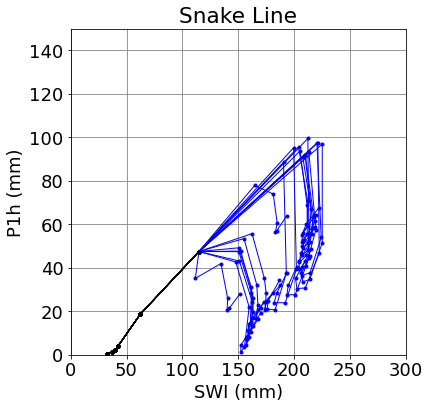

In [1390]:
# クリックした地点でのスネーク曲線を描画
swi6 = swi4_e.sel(LON=lon1, LAT=lat1, method="nearest") 
p1h6 = p1h4_e.sel(LON=lon1, LAT=lat1, method="nearest") 
draw_snake_line_ens(swi6, p1h6, nmax)

クリックした地点は全メンバー同じであるので、過去及び現在のスネーク曲線は同じになる

In [1391]:
#ind5 = calc_landslide_lisk_index(swi5, swi5)
#draw_landslide_lisk_index_ens(ind5, nmax)
#for i in range(nmax): 
#    swi5.isel(m=i).plot()
#    p1h5.isel(m=i).plot()
#    ind5.isel(m=i).plot()

以降の max, medeia, mean を選ぶ作業は、(3)の場合と同様. 